In [35]:
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.nn import functional as F
from collections import deque
import time
import os

#Deep Q Network implimantation
class DQN(nn.Module):
    def __init__(self, num_states, num_actions) -> None:
        super().__init__()
        self.fc1 = nn.Linear(num_states, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.out(x)

#define memory for experience replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen= maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    
    def __len__(self):
        return len(self.memory)

# state to dqn_input function as both are little bit different
def state_to_dqn_input(state):
    input = torch.zeros(16)
    input[state] = 1
    return input

#epsilon greedy action selection
def epsilon_greedy_action(state, policy_dqn, env, epsilon):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    
    else:
        with torch.no_grad():
            dqn_input = state_to_dqn_input(state)
            q_values = policy_dqn(dqn_input)
        return q_values.argmax().item()

#training the q neural nets
def optimize(discount_factor_g, batch, policy_dqn, target_dqn, loss_fn, optimizer):

    num_states=16

    # Unpack the batch and convert its components to tensors for vectorized operations.
    states = torch.stack([state_to_dqn_input(s) for s, a, ns, r, t in batch])
    actions = torch.tensor([a for s, a, ns, r, t in batch], dtype=torch.int64).unsqueeze(-1)
    next_states = torch.stack([state_to_dqn_input(ns) for s, a, ns, r, t in batch])
    rewards = torch.tensor([r for s, a, ns, r, t in batch], dtype=torch.float32)
    terminated_flags = torch.tensor([t for s, a, ns, r, t in batch], dtype=torch.float32)

    current_q_values = policy_dqn(states).gather(1, actions).squeeze(-1)

    with torch.no_grad(): # Gradients are not needed for the target calculation.
        # Get the maximum Q-value for the next state from the target network.
        next_q_values = target_dqn(next_states).max(1).values
        # The value of a terminal state is 0.
        next_q_values[terminated_flags == 1] = 0.0
        # Calculate the target value: R + gamma * max_a' Q_target(s', a')
        target_q_values = rewards + (discount_factor_g * next_q_values)
    
    #loss
    loss = loss_fn(current_q_values, target_q_values)

    #optimize the model 
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_dqn.parameters(), max_norm=1.0)
    optimizer.step()

def run(num_episodes, is_slippery=True, render_mode=None):
    env = gym.make("FrozenLake-v1", is_slippery = is_slippery, render_mode = render_mode)

    #env paramenters
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    #hyperparameters
    discount_factor_g = 0.99

    #to track reward per episode
    reward_per_episode = np.zeros(num_episodes)

    #epsilon decay rate for random exploration
    epsilon_start = 1.0      #100% exploatation
    epsilon_end = 0.01       #some exploration at the end
    epsilon_decay_episodes = num_episodes * 0.8
    epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_episodes

    # policy and target dqn 
    policy_dqn = DQN(num_states=num_states, num_actions=num_actions)
    target_dqn = DQN(num_states=num_states, num_actions=num_actions)
    #make target_dqn same as policy_dqn
    target_dqn.load_state_dict(policy_dqn.state_dict())

    #DQN neural net parameters
    batch_size = 256
    learning_rate_a = 0.0001
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate_a)

    step_count = 0
    network_sync_rate = 10      #after 10 episode copy the policy to target

    #crete memory block for recording episode and steps
    replay_memory_size = 50000
    memory = ReplayMemory(replay_memory_size)

    for i_episode in range(num_episodes):
        epsilon = max(epsilon_end, epsilon_start - epsilon_decay * i_episode)
        state, info = env.reset()
        terminated = False
        truncated = False
    
        while (not terminated and not truncated):
            action = epsilon_greedy_action(state, policy_dqn, env=env, epsilon=epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)

            #save the current transion to memory
            memory.append((state, action, next_state, reward, terminated))

            state = next_state
            step_count += 1

            #keep track of reward at every episode
            if terminated and reward == 1:
                reward_per_episode[i_episode] = 1

        #optimize at every completion of episode, talking sample from memory
        #start this when memory size > batch size and after first sucess
        if len(memory)>batch_size:
            batch = memory.sample(batch_size)
            optimize(discount_factor_g, batch, policy_dqn, target_dqn, loss_fn, optimizer)

        if i_episode % network_sync_rate == 0:
            target_dqn.load_state_dict(policy_dqn.state_dict())

        if (i_episode + 1) % 100 == 0:
            avg_reward = np.mean(reward_per_episode[max(0, i_episode-99):(i_episode+1)])
            print(f"Episode {i_episode+1}/{num_episodes} | Epsilon: {epsilon:.3f} | Avg Reward (last 100): {avg_reward:.2f}")

    #close env
    env.close()

    #save the policy
    torch.save(policy_dqn.state_dict(), "05_dql.pt")

    #ploting the average rewards per episode
    sum_rewards = np.zeros(num_episodes)
    for x in range(num_episodes):
        sum_rewards[x] = np.sum(reward_per_episode[max(0, x-99):(x+1)])
    
    plt.figure(figsize=(12, 6))
    plt.plot(sum_rewards)
    plt.title('Agent Performance: Moving Sum of Rewards (Window=100)')
    plt.xlabel('Episode')
    plt.ylabel('Total Successful Episodes in Last 100')
    plt.grid(True)
    plt.show()

#testing the results
def test(num_episodes, is_slippery=True, render_mode=None):
    # Create FrozenLake instance
    env = gym.make('FrozenLake-v1', is_slippery=is_slippery, render_mode=render_mode)
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Load learned policy
    policy_dqn = DQN(num_states=num_states, num_actions=num_actions)
    policy_dqn.load_state_dict(torch.load("05_dql.pt"))
    policy_dqn.eval()    # switch model to evaluation mode

    for i in range(num_episodes):
        state, info = env.reset()
        terminated = False      # True when agent falls in hole or reached goal
        truncated = False       # True when agent takes more than 200 actions            

        while(not terminated and not truncated):   
            with torch.no_grad():
                action = policy_dqn(state_to_dqn_input(state)).argmax().item()

            # Execute action
            state,reward,terminated,truncated,info = env.step(action)

    env.close()


Episode 100/10000 | Epsilon: 0.988 | Avg Reward (last 100): 0.02
Episode 200/10000 | Epsilon: 0.975 | Avg Reward (last 100): 0.00
Episode 300/10000 | Epsilon: 0.963 | Avg Reward (last 100): 0.02
Episode 400/10000 | Epsilon: 0.951 | Avg Reward (last 100): 0.02
Episode 500/10000 | Epsilon: 0.938 | Avg Reward (last 100): 0.00
Episode 600/10000 | Epsilon: 0.926 | Avg Reward (last 100): 0.00
Episode 700/10000 | Epsilon: 0.913 | Avg Reward (last 100): 0.03
Episode 800/10000 | Epsilon: 0.901 | Avg Reward (last 100): 0.00
Episode 900/10000 | Epsilon: 0.889 | Avg Reward (last 100): 0.02
Episode 1000/10000 | Epsilon: 0.876 | Avg Reward (last 100): 0.03
Episode 1100/10000 | Epsilon: 0.864 | Avg Reward (last 100): 0.03
Episode 1200/10000 | Epsilon: 0.852 | Avg Reward (last 100): 0.04
Episode 1300/10000 | Epsilon: 0.839 | Avg Reward (last 100): 0.02
Episode 1400/10000 | Epsilon: 0.827 | Avg Reward (last 100): 0.01
Episode 1500/10000 | Epsilon: 0.814 | Avg Reward (last 100): 0.02
Episode 1600/10000 

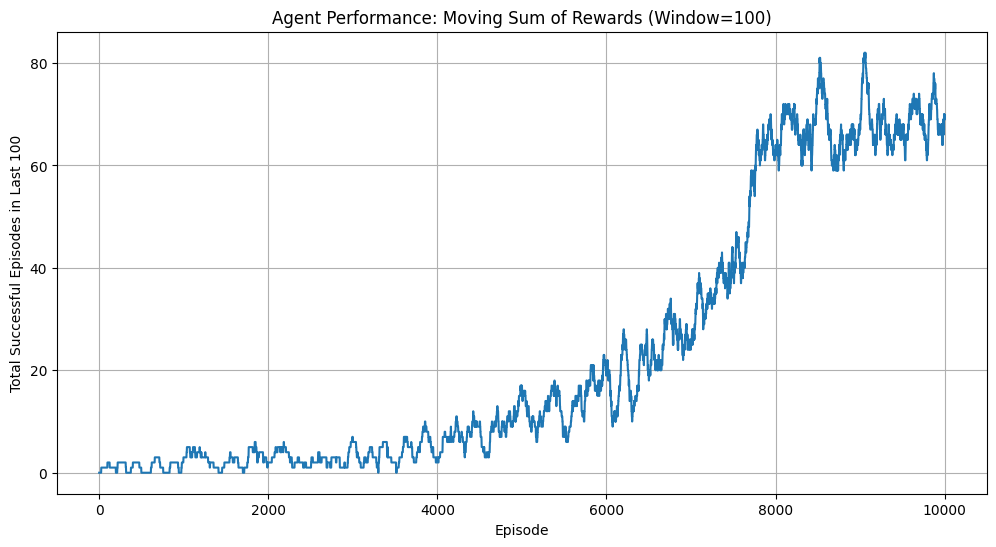

In [37]:
run(10000)

In [38]:
test(2, is_slippery=True, render_mode='human')